# Can we predict anything about the antibiotic usage?

Lets start with '3 tobramycin_IV' because we have lots of pwCF with that!

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text

from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


In [2]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "genus"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

Mean Squared Error for all bacteria: 0.14368076923076922


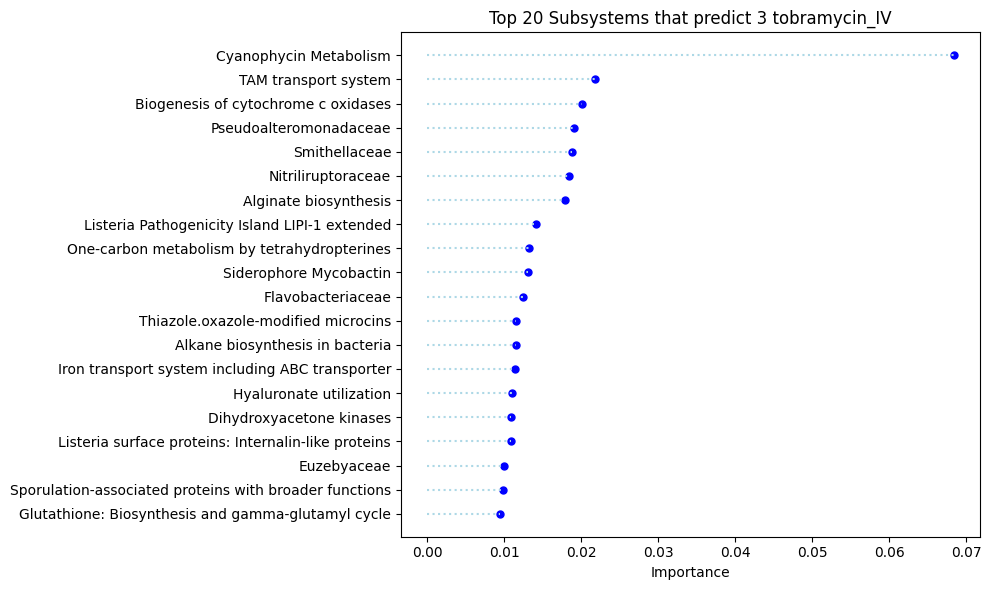

In [3]:
# this approach uses an inner join to ensure that we have the same 'interesting column' (intcol) 
# data in the same order as the data frame
intcol = '3 tobramycin_IV'
merged_df = df.join(metadata[[intcol]]).dropna()

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if metadata[intcol].dtype == 'object':
  mse, feature_importances_sorted = cf_analysis_lib.random_forest_classifier(X, y, n_estimators=100)
  met = 'classification'
else:
  mse, feature_importances_sorted = cf_analysis_lib.random_forest_regression(X, y, n_estimators=100)
  met = 'regression'


print(f"Mean Squared Error for all bacteria: {mse}")

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=1)

cf_analysis_lib.plot_feature_importance(axes, feature_importances_sorted[:20], f"Top 20 Subsystems that predict {intcol}")


plt.tight_layout()
plt.show()

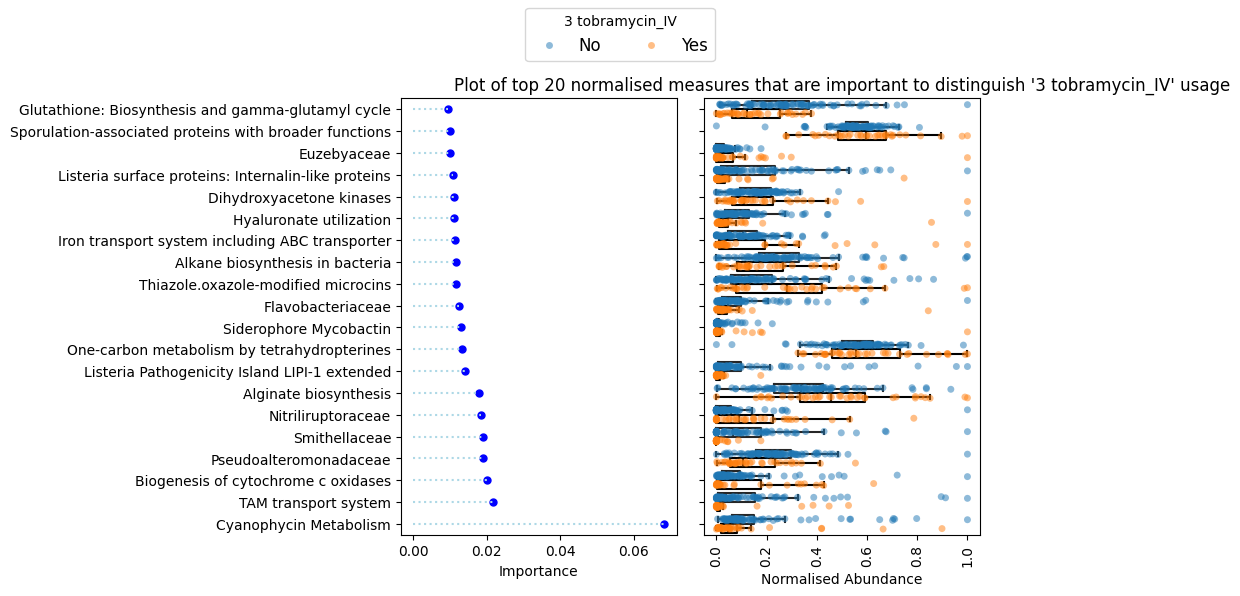

In [7]:
n = 20
topN = list(feature_importances_sorted[:n].index)+[intcol]

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2, sharey=True)
title=f"Plot of top {n} normalised measures that are important to distinguish '{intcol}' usage"
cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:n], "")
cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN], intcol, title)

custom_labels = {0: 'No', 1: 'Yes'}
handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[int(label)] for label in labels]

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, fontsize=12, title=intcol)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [8]:
feature_importances_sorted

,importance
Cyanophycin Metabolism,0.068359
TAM transport system,0.021760
Biogenesis of cytochrome c oxidases,0.020141
Pseudoalteromonadaceae,0.019060
Smithellaceae,0.018867
...,...
RuBisCO operon,0.000000
"Ribosome biogenesis, archaeal",0.000000
Ribosome activity modulation,0.000000
"Ribosome SSU, eukaryotic and archaeal",0.000000


In [14]:
metadata[antibiotics]

,1 Cephalexin_PO,1 Flucloaxcillin_PO,1 Itraconazole (Lozenoc)_PO,1 Sulfamethoxazole_trimethoprim (Bactrim)_PO,2 Amikacin_INH,2 Amoxicillin & Potassium clavulanate (Aug Duo)_PO,2 Amphotericin B (Ambisome)_INH,2 Azithromycin_PO,2 Ceftazidime_INH,2 Ciprofloxacin_PO,...,3 Imipenem,3 Ivacaftor (Kalydeco),3 Meropenem_IV,3 Methylpredinosolone_IV,3 Omalizumab_SC,"3 piperacillin sodium, tazobactam sodium (Tazocin)_IV",3 tobramycin_IV,4 Amikacin_IV,4 Cefoxitin_IV,4 Colistin_IV
NAME,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1085876_20180227_S,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1128691_20171206_S,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1128691_20171218_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1128691_20180116_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896213_20180427_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
913873_20180417_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# All antibiotics.

At this stage, we are going to filter for those antibiotics where we have more than 6 data points, so not quite all!

In [20]:
antibiotics = ['1 Cephalexin_PO', '1 Flucloaxcillin_PO', '1 Itraconazole (Lozenoc)_PO', '1 Sulfamethoxazole_trimethoprim (Bactrim)_PO', '2 Amikacin_INH', '2 Amoxicillin & Potassium clavulanate (Aug Duo)_PO', '2 Amphotericin B (Ambisome)_INH', '2 Azithromycin_PO', '2 Ceftazidime_INH', '2 Ciprofloxacin_PO', '2 Clarithromycin_PO', '2 Clofazimine PO', '2 Colistin_IHN', '2 prednisolone_PO', '2 tobramycin_INH', '3 Azithromycin_IV', '3 Aztreonam_IV', '3 Cefopime_IV', '3 Ceftazidime_IV', '3 Imipenem', '3 Ivacaftor (Kalydeco)', '3 Meropenem_IV', '3 Methylpredinosolone_IV', '3 Omalizumab_SC', '3 piperacillin sodium, tazobactam sodium (Tazocin)_IV', '3 tobramycin_IV', '4 Amikacin_IV', '4 Cefoxitin_IV', '4 Colistin_IV']

mda = metadata.copy()
mda[antibiotics] = mda[antibiotics].apply(pd.to_numeric, errors='coerce')
mda[antibiotics] = mda[antibiotics].fillna(0).astype(int)

antibiotic_counts = mda[antibiotics].sum(axis=0)
antibiotic_counts[antibiotic_counts > 6].index

Index(['1 Itraconazole (Lozenoc)_PO',
       '2 Amoxicillin & Potassium clavulanate (Aug Duo)_PO',
       '2 Azithromycin_PO', '2 Ciprofloxacin_PO', '2 tobramycin_INH',
       '3 Ceftazidime_IV', '3 Methylpredinosolone_IV',
       '3 piperacillin sodium, tazobactam sodium (Tazocin)_IV',
       '3 tobramycin_IV', '4 Amikacin_IV'],
      dtype='object')

1 Itraconazole (Lozenoc)_PO	regression	0.07
2 Amoxicillin & Potassium clavulanate (Aug Duo)_PO	regression	0.04
2 Azithromycin_PO	regression	0.00
2 Ciprofloxacin_PO	regression	0.05
2 tobramycin_INH	regression	0.13
3 Ceftazidime_IV	regression	0.06
3 Methylpredinosolone_IV	regression	0.04
3 piperacillin sodium, tazobactam sodium (Tazocin)_IV	regression	0.11
3 tobramycin_IV	regression	0.14
4 Amikacin_IV	regression	0.04


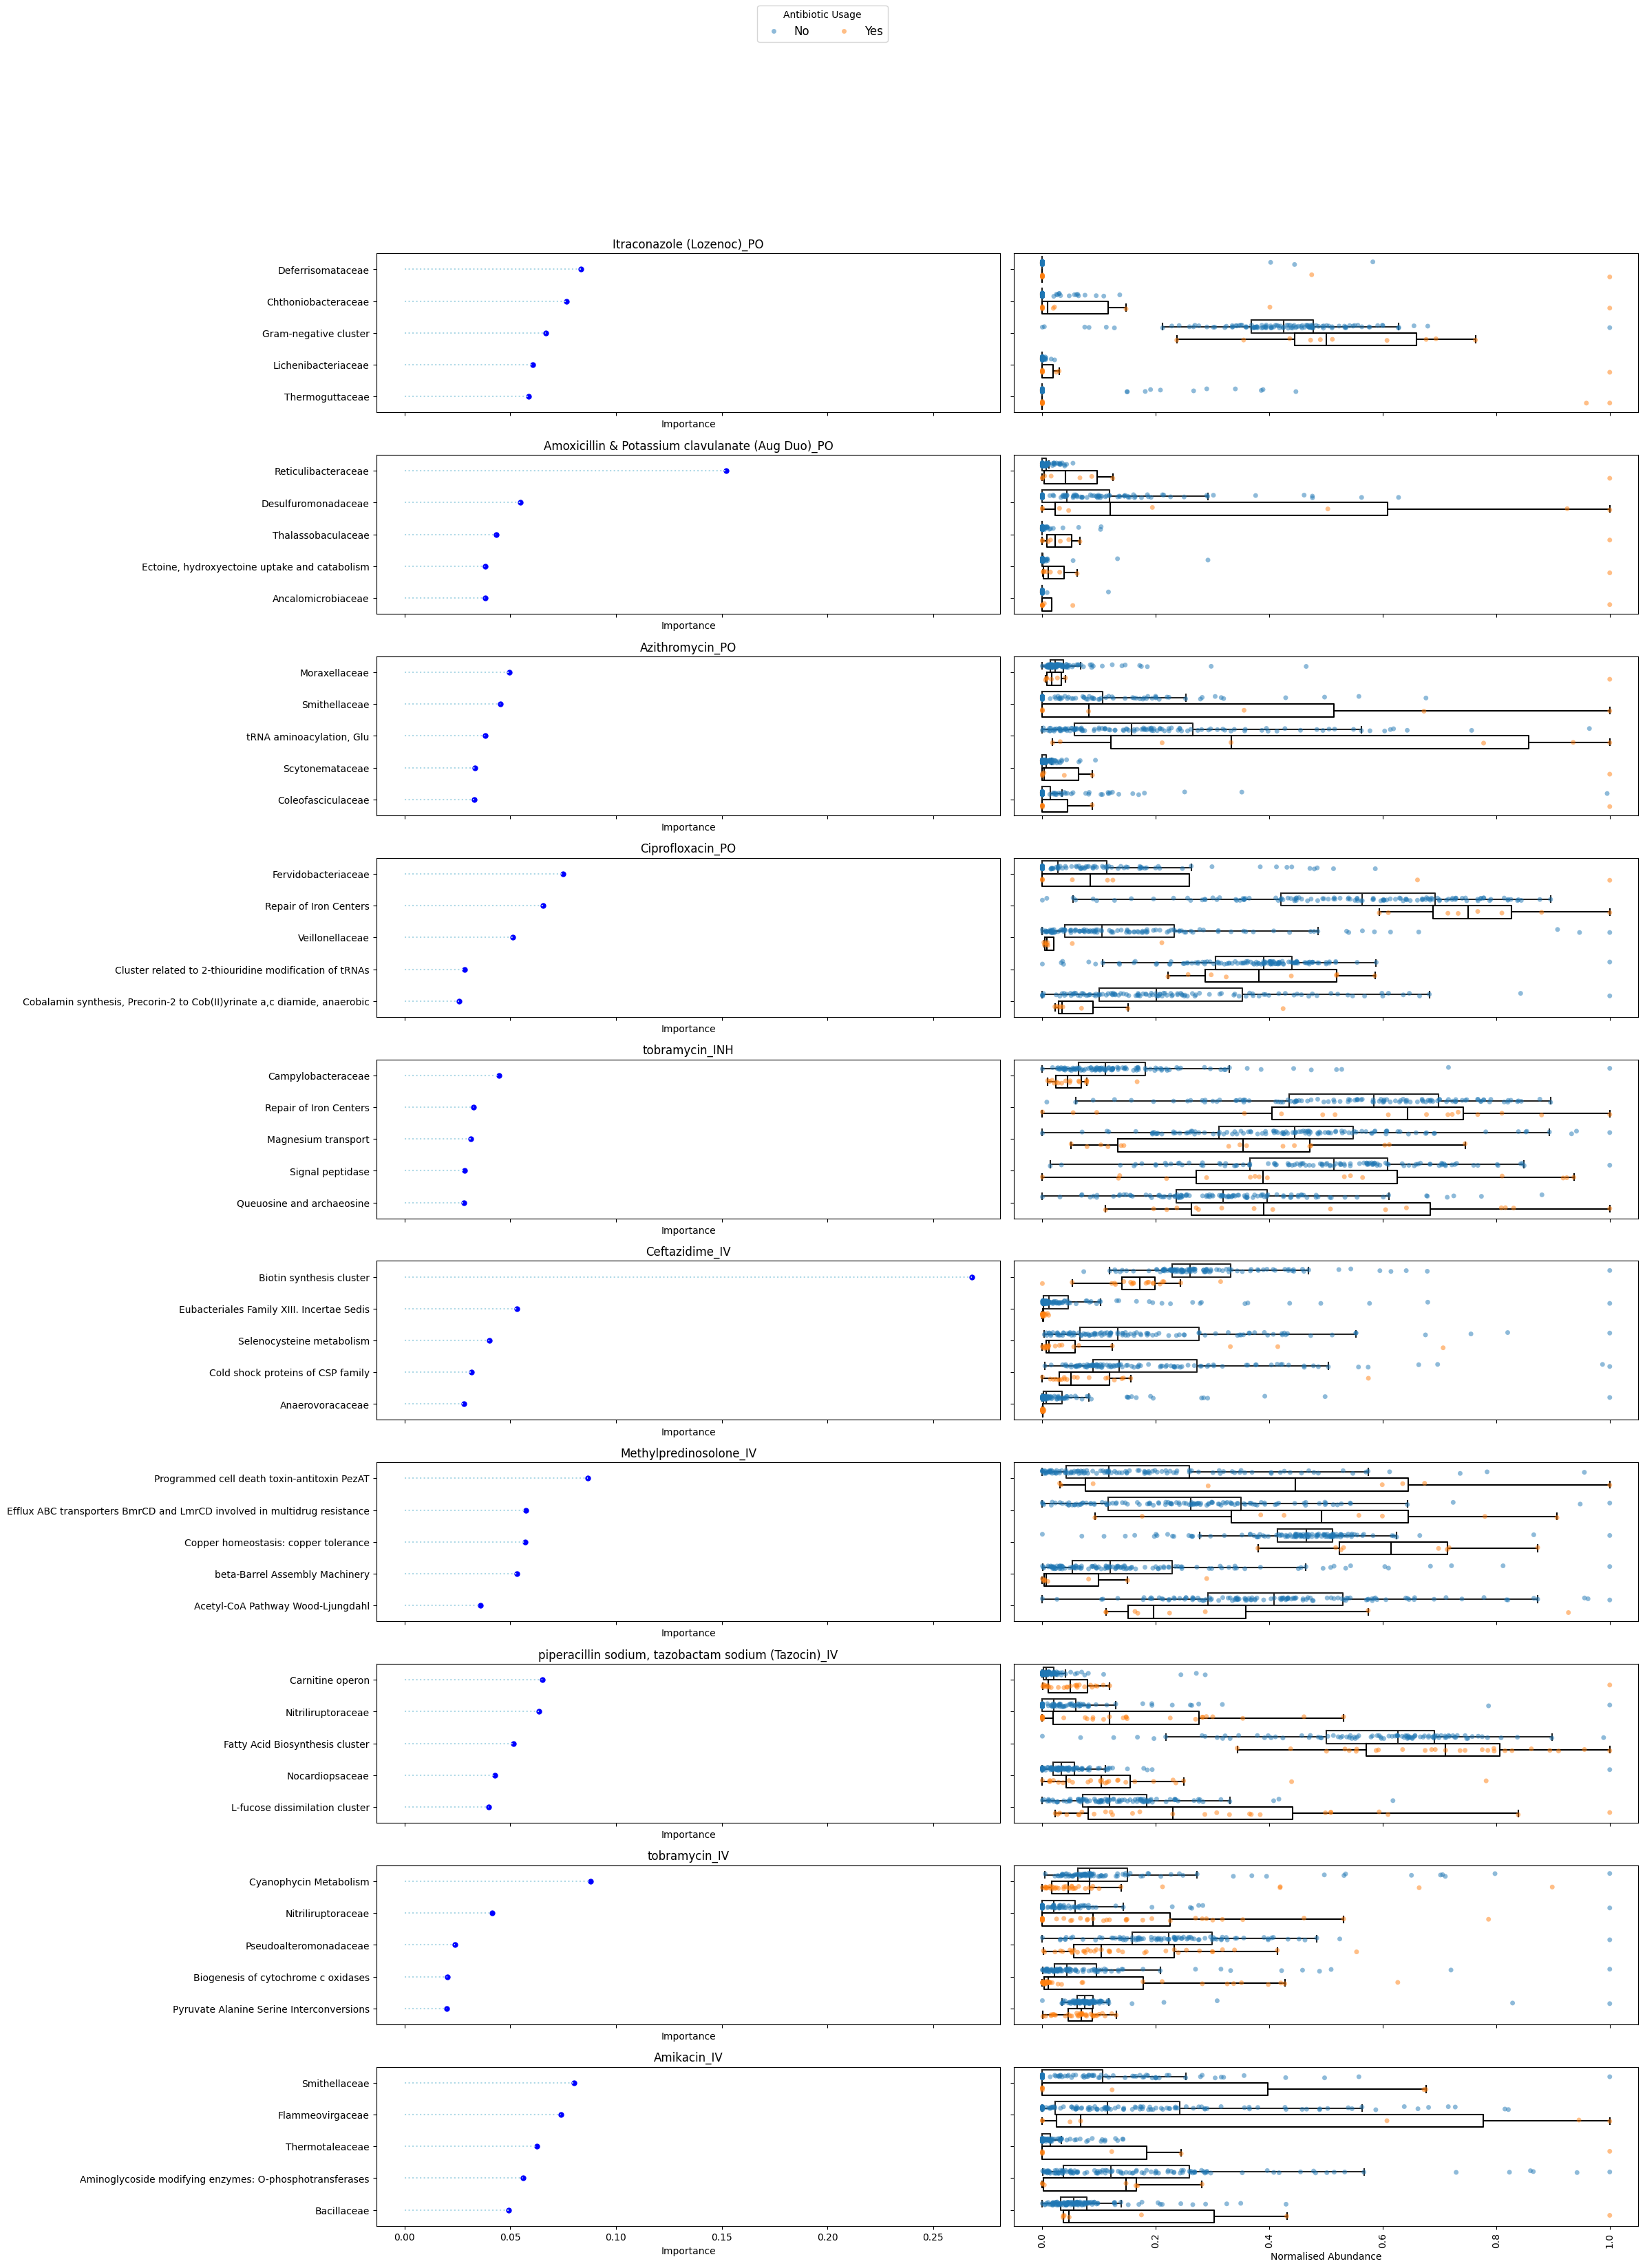

In [24]:
# this approach uses an inner join to ensure that we have the same 'interesting column' (intcol) 
# data in the same order as the data frame

minab = 6
numsamples = len(antibiotic_counts[antibiotic_counts > minab].index)
replace_index = re.compile(r'^\d+\s+')

fig, axes = plt.subplots(figsize=(24,33), nrows=numsamples, ncols=2, sharey='row', sharex='col')
for rownum, intcol in enumerate(antibiotic_counts[antibiotic_counts > minab].index):
    merged_df = df.join(metadata[[intcol]]).dropna()
    X = merged_df.drop(intcol, axis=1)
    y = merged_df[intcol]
    
    if metadata[intcol].dtype == 'object':
      mse, feature_importances_sorted = cf_analysis_lib.random_forest_classifier(X, y)
      met = 'classification'
    else:
      mse, feature_importances_sorted = cf_analysis_lib.random_forest_regression(X, y)
      met = 'regression'

    print(f"{intcol}\t{met}\t{mse:.2f}")
    
    n = 5
    topN = list(feature_importances_sorted[:n].index)+[intcol]
    

    #title=f"Plot of top {n} normalised measures that are important to distinguish '{intcol}' usage"
    
    cf_analysis_lib.plot_feature_importance(axes[rownum, 0], feature_importances_sorted[:n][::-1], replace_index.sub('', intcol))
    cf_analysis_lib.plot_feature_abundance(axes[rownum, 1], merged_df[topN][::-1], intcol, "")
    
custom_labels = {0: 'No', 1: 'Yes'}
handles, labels = axes[0,1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[int(label)] for label in labels]

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()
    
plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, fontsize=12, title='Antibiotic Usage')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('img/ab_usage.png')
plt.show()

# Are there more macrolides in the RAH than WCH?

Morgyn will like this!

In [45]:
macrolides = [x for x in metadata.columns if 'Azithromycin' in x or 'Clarithromycin' in x]
macrolides

['3 Azithromycin_IV', '2 Azithromycin_PO', '2 Clarithromycin_PO']

In [46]:
mda['Macrolides'] = mda[macrolides].any(axis=1).astype(int)
mda[mda['Macrolides'] == 1][['Hospital', 'Age'] + macrolides + ['Macrolides']]

,Hospital,Age,3 Azithromycin_IV,2 Azithromycin_PO,2 Clarithromycin_PO,Macrolides
NAME,,,,,,
1085876_20180227_S,RAH,40,0,1,0,1
1664053_20180406_S,RAH,26,0,1,0,1
650003_20180207_S,WCH,17,0,1,0,1
650003_20180213_S,WCH,17,0,1,0,1
698917_20180119_S,WCH,14,0,0,1,1
698917_20180128_S,WCH,14,0,0,1,1
698917_20180329_S,WCH,14,0,1,0,1
717449_20180606_S,WCH,14,0,1,0,1
770560_20181218_S,WCH,12,0,1,0,1


In [51]:
metadata[metadata['Hospital'] == 'RAH'].shape

(33, 166)

In [41]:
mda

,minion,MGI,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,Paediatric vs Adult,...,Sum of antifungals,Sum of steroid + mabs,DNA_extraction_ conc,SAGC ULN,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million),Macrolides
NAME,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,1068841_20180306_S,1068841_20180306_S,1068841,2018-03-06,OP,RAH,Chest Clinic 7,47,7,Adult,...,0,0,1.070,SAGCFN_22_01754,42.800,CGCTCATT,ATAGAGGC,417,2.8,0
1085876_20180227_S,NaN,1085876_20180227_S,1085876,2018-02-27,OP,RAH,Chest Clinic 6,40,6,Adult,...,0,0,0.132,SAGCFN_22_01828,19.000,AGCGATAG,GGCTCTGA,674,2.5,1
1128691_20171206_S,NaN,1128691_20171206_S,1128691,2017-12-06,IP,RAH,RAH 8E 05,47,7,Adult,...,0,0,1.750,SAGCFN_22_01748,33.400,TCCGGAGA,GGCTCTGA,535,4.5,0
1128691_20171218_S,1128691_20171218_S,1128691_20171218_S,1128691,2017-12-18,OP,RAH,Chest Clinic 1,47,7,Adult,...,0,0,3.400,SAGCFN_22_01743,30.800,ATTACTCG,CAGGACGT,352,4.8,0
1128691_20180116_S,1128691_20180116_S,1128691_20180116_S,1128691,2018-01-16,OP,RAH,Chest Clinic 4,47,7,Adult,...,0,0,0.708,SAGCFN_22_01772,27.400,ATTCAGAA,GGCTCTGA,500,3.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,895293_20180502_S,895293_20180502_S,895293,2018-05-02,OP,RAH,TMO Lounge,47,7,Adult,...,0,0,0.442,SAGCFN_22_01787,16.900,CTGAAGCT,CCTATCCT,584,4.6,0
896213_20180427_S,NaN,896213_20180427_S,896213,2018-04-27,OP,WCH,Level 6 Treatment,6,1,Paediatric,...,0,0,0.000,SAGCFN_22_01854,0.436,CCACAGCCTT,CTTCAATAGC,477,0.2,0
913873_20180417_S,NaN,913873_20180417_S,913873,2018-04-17,IP,WCH,Cassia 17,6,1,Paediatric,...,0,0,0.000,SAGCFN_22_01853,0.162,CCAGACCGAT,TGCAAGTAGC,863,0.0,0
